In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline



In [4]:
# Load the data
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_07_18_2024, 15_09_00_to_09_18_2024, 15_09_00.xlsx'
xls = pd.ExcelFile(file_path)
data_sheet = pd.read_excel(xls, sheet_name='Data')


In [5]:
# Sort the data by 'trip' and 'Time' to maintain chronological order
data_sheet = data_sheet.sort_values(by=['trip', 'time']).reset_index(drop=True)

# Reset 'Time' to start at 0 for each trip
data_sheet['time'] = data_sheet.groupby('trip')['time'].transform(lambda x: x - x.min())

# Verify that 'Time' starts at 0 for each trip
assert (data_sheet.groupby('trip')['time'].first() == 0).all(), "Time did not reset to 0 for some trips."




In [7]:
# Identify trips where 'Time' does not start at 0
invalid_trips = data_sheet[data_sheet['time'] < 0]['trip'].unique()
if len(invalid_trips) > 0:
    print(f"Trips with invalid Time reset: {invalid_trips}")
    # Optionally, remove these trips
    data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]


In [13]:
# Filter out trips with fewer than 500 observations
filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

# Extract unique trips
unique_trips = filtered_trips['trip'].unique()

# Define temperature bins and labels based on your data's temperature range
temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

# Function to assign a group based on initial coolant temperature
def assign_group(trip_data):
    initial_temp = trip_data['Coolant_temperature'].iloc[0]
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        return 'Other'
    return group

# Create a DataFrame mapping each trip to its group
trip_groups = pd.DataFrame({
    'trip': unique_trips,
    'group': [
        assign_group(filtered_trips[filtered_trips['trip'] == trip])
        for trip in unique_trips
    ]
})

# Merge 'group' information back into 'filtered_trips'
filtered_trips = filtered_trips.merge(trip_groups, on='trip', how='left')

# Verify the merge
if filtered_trips['group'].isnull().any():
    missing_groups = filtered_trips[filtered_trips['group'].isnull()]['trip'].unique()
    print(f"Trips with missing group information: {missing_groups}")
    # Optionally, handle these trips (e.g., assign to 'Other' or remove)
    filtered_trips['group'].fillna('Other', inplace=True)

# Create directories to save group-specific models
os.makedirs('models/groups', exist_ok=True)

def train_and_save_svr_model(group_name, group_data, models_dir='models/groups'):
    """
    Trains an SVR model for a specific group and saves the trained model.

    Parameters:
    - group_name (str): The name of the group.
    - group_data (DataFrame): The data corresponding to the group.
    - models_dir (str): Directory to save the trained models.

    Returns:
    - dict: A dictionary containing evaluation metrics for the group.
    """
    # Define features and target
    X = group_data[['time', 'Vehicle_Speed', 'Engine_speed']].values
    y = group_data['Coolant_temperature'].values

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create a pipeline with StandardScaler and SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1))
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Group: {group_name} | MSE: {mse:.2f} | MAE: {mae:.2f}")

    # Define the model file path
    model_filename = f"{group_name}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    # Save the trained pipeline (scaler + SVR)
    joblib.dump(pipeline, model_path)

    return {
        'group': group_name,
        'mse': mse,
        'mae': mae,
        'model_path': model_path
    }

# List to store evaluation results
evaluation_results = []

# Define the number of parallel jobs (you can adjust this based on your CPU)
num_jobs = -1  # Use all available cores

# Function to process each group
def process_group(group_name):
    group_data = filtered_trips[filtered_trips['group'] == group_name]
    return train_and_save_svr_model(group_name, group_data)

# Train models in parallel
evaluation_results = Parallel(n_jobs=num_jobs)(
    delayed(process_group)(group_name) for group_name in trip_groups['group'].unique()
)

# Convert evaluation results to DataFrame for easier analysis
evaluation_df = pd.DataFrame(evaluation_results)
print("\nModel Training Evaluation:")
print(evaluation_df)


Model Training Evaluation:
     group        mse       mae                              model_path
0   55-65C   5.687176  1.716385   models/groups/55-65C_svr_model.joblib
1   75-85C   8.803578  2.147489   models/groups/75-85C_svr_model.joblib
2   85-95C   8.420485  2.124709   models/groups/85-95C_svr_model.joblib
3   65-75C  51.297766  3.417093   models/groups/65-75C_svr_model.joblib
4   35-45C  36.657003  3.997519   models/groups/35-45C_svr_model.joblib
5   25-35C  22.801894  3.183251   models/groups/25-35C_svr_model.joblib
6    Other  38.173819  2.663335    models/groups/Other_svr_model.joblib
7   45-55C   5.681045  1.714554   models/groups/45-55C_svr_model.joblib
8  95-105C   0.671846  0.582992  models/groups/95-105C_svr_model.joblib
9    0-25C   2.578418  0.816986    models/groups/0-25C_svr_model.joblib


In [14]:
def predict_coolant_temperature(new_trip_data, trip_groups_df, models_dir='models/groups'):
    """
    Predicts the Coolant_temperature for a new trip using the appropriate SVR model.

    Parameters:
    - new_trip_data (DataFrame): The data for the new trip with columns ['Time', 'Vehicle_Speed', 'Engine_speed', 'Coolant_temperature'].
    - trip_groups_df (DataFrame): DataFrame mapping trips to groups.
    - models_dir (str): Directory where models are saved.

    Returns:
    - DataFrame: The new_trip_data with an additional column 'Predicted_Coolant_temperature'.
    """
    # Ensure the trip_data is sorted by Time
    new_trip_data = new_trip_data.sort_values(by='time').reset_index(drop=True)

    # Get the initial coolant temperature to determine the group
    initial_temp = new_trip_data['Coolant_temperature'].iloc[0]

    # Define temperature bins and labels (ensure consistency with training)
    temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]
    temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]

    # Assign group
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        group = 'Other'

    print(f"Assigned Group: {group}")

    # Load the corresponding model
    model_filename = f"{group}_svr_model.joblib"
    model_path = os.path.join(models_dir, model_filename)

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No model found for group '{group}'. Please ensure the model is trained and saved.")

    model = joblib.load(model_path)

    # Prepare features for prediction
    X_new = new_trip_data[['time', 'Vehicle_Speed', 'Engine_speed']].values

    # Predict
    predicted_temp = model.predict(X_new)

    # Add predictions to the DataFrame
    new_trip_data['Predicted_Coolant_temperature'] = predicted_temp

    return new_trip_data


In [17]:
# Example: Forecasting for the last trip in the dataset
last_trip = unique_trips[-1]
new_trip_data = filtered_trips[filtered_trips['trip'] == last_trip].copy()

# Ensure 'Time' resets to 0 for the new trip
new_trip_data['time'] = new_trip_data['time'] - new_trip_data['time'].min()

# Predict coolant temperature
predicted_trip = predict_coolant_temperature(new_trip_data, trip_groups)



Assigned Group: 35-45C


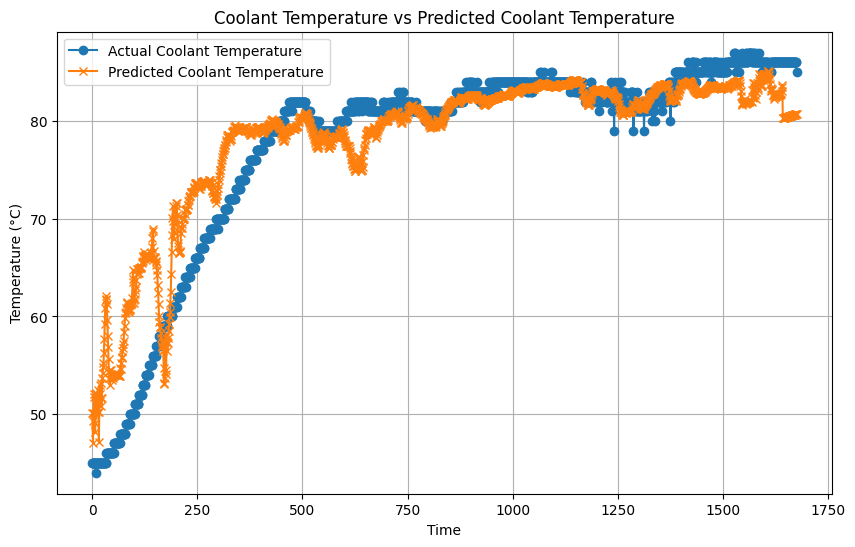

In [19]:
plt.figure(figsize=(10,6))
plt.plot( predicted_trip['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
plt.plot( predicted_trip['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

# Adding titles and labels
plt.title('Coolant Temperature vs Predicted Coolant Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

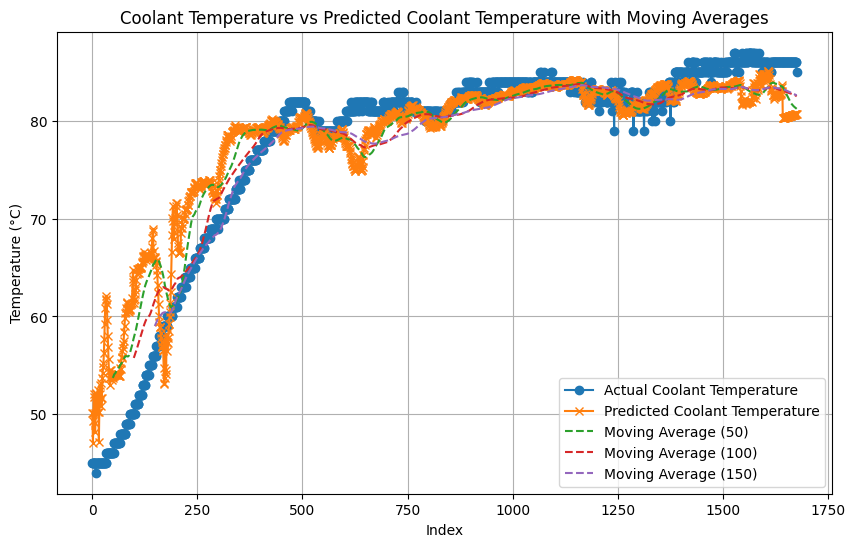

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a dataframe called 'predicted_trip'
# Example:
# predicted_trip = pd.DataFrame({
#     'Coolant_temperature': [70, 72, 75, 78, 80, 82, 85, 88, 90, 92, 94, 95, 96, 97, 98],
#     'Predicted_Coolant_temperature': [71, 73, 74, 77, 81, 83, 85, 87, 89, 91, 93, 94, 95, 96, 97]
# })

# Calculate moving averages
predicted_trip['MA_50'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=50).mean()
predicted_trip['MA_100'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=100).mean()
predicted_trip['MA_150'] = predicted_trip['Predicted_Coolant_temperature'].rolling(window=150).mean()

# Plotting
plt.figure(figsize=(10,6))

# Plot actual coolant temperature and predicted coolant temperature using index
plt.plot(predicted_trip.index, predicted_trip['Coolant_temperature'], label='Actual Coolant Temperature', marker='o')
plt.plot(predicted_trip.index, predicted_trip['Predicted_Coolant_temperature'], label='Predicted Coolant Temperature', marker='x')

# Plot moving averages
plt.plot(predicted_trip.index, predicted_trip['MA_50'], label='Moving Average (50)', linestyle='--')
plt.plot(predicted_trip.index, predicted_trip['MA_100'], label='Moving Average (100)', linestyle='--')
plt.plot(predicted_trip.index, predicted_trip['MA_150'], label='Moving Average (150)', linestyle='--')

# Adding titles and labels
plt.title('Coolant Temperature vs Predicted Coolant Temperature with Moving Averages')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()